* we will use linear regression model as the basic model.
* we will use rmse as the accuracy metric, (and r_2) 
* initially we will not do feature normalization
* afterward, we will do feature normalization to see it's impact. 
* then we will do feature engineering, for starter we will remove correlated feature
* first, we will use initial 80% as train, and later 20% as test from the same dataset.
* then we will train on one dataset, and test on others to check transferability
* we will train one linear regression model for one output variable
* while calculating R^2 and and RMSE we will do that for each individual output variable
* We will average for all six to report a single accuracy metric

In [17]:
# import packages
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np
import statsmodels.api as sm
from pygam import LinearGAM
import lightgbm as lgb
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.neural_network import MLPRegressor
import warnings
warnings.filterwarnings("ignore")

In [18]:
# read data 
data_1 = pd.read_csv('Test1.csv')
data_2 = pd.read_csv('Test2.csv')
data_4 = pd.read_csv('Test4.csv')

# Note
* We discard the first 2% and last 2% of the data as they are during starting and ending phase. Intuitively decided from the 3D plots.
* We exclude x_enc_2, as same as x_enc_1

In [19]:
columns_1 = data_1.columns

feature_columns = ['a_enc_1', 'b_enc_1', 'c_enc_1', 'x_enc_1', 'y_enc_1', \
                   'z_enc_1', 'a_enc_2', 'b_enc_2', 'c_enc_2', 'y_enc_2', 'z_enc_2']
output_columns = ['fx_1', 'fy_1', 'fz_1', 'fx_2', 'fy_2', 'fz_2']

In [20]:
def filter_data(data):
    n_sample = data.shape[0]
    data = data[int(0.02*n_sample):int(0.98*n_sample)][feature_columns + output_columns]
    return data

data_1 = filter_data(data_1)
data_2 = filter_data(data_2)
data_4 = filter_data(data_4)

# Define model dictioanry

In [21]:
model_dict = {'lr' : LinearRegression(),
             'gam' : LinearGAM(),
             'lgbm' : LGBMRegressor(),
             'xgb' : XGBRegressor(objective='reg:squarederror'),
             'mlp' : MLPRegressor(hidden_layer_sizes=(8,8),activation="relu", random_state=1, max_iter=500)}

# feature normalization

In [22]:
def normalize_data(Train, Test):
    Train = Train.values
    Test  = Test.values
    min_max_scaler = MinMaxScaler()
    min_max_scaler.fit(Train)
    Train = min_max_scaler.transform(Train)
    Test  = min_max_scaler.transform(Test)
    Train = sm.add_constant(Train)
    Test  = sm.add_constant(Test)
    return Train, Test

# Train-test function

In [23]:
def train_test(model, X_train, X_test, Y_train, Y_test):
    model.fit(X_train, Y_train)
    Y_predict = model.predict(X_test)
    Y_test_rmse = np.sqrt(mean_squared_error(Y_test, Y_predict))
    Y_test_r2 = r2_score(Y_test, Y_predict)
    return Y_test_rmse, Y_test_r2

# Train-test on same data

In [24]:
# create train-test data. first 80% as train, rest as test
def get_train_test(data):
    n_sample = data.shape[0]
    train = data[:int(0.8*n_sample)]
    test = data[int(0.8*n_sample):]
    return train, test

In [25]:
# create train-test data
def get_accuracy(model, data):
    train, test     = get_train_test(data)
    X_train         = train[feature_columns]
    X_test          = test[feature_columns]
    X_train, X_test = normalize_data(X_train, X_test)
    rmse_dict       = {}
    r2_dict         = {}
    for output_column in output_columns:
        Y_train  = train[[output_column]]
        Y_test   = test[[output_column]]
        rmse, r2 = train_test(model, X_train, X_test, Y_train, Y_test)
        rmse_dict[output_column] = rmse
        r2_dict[output_column]   = r2
        
    return rmse_dict, r2_dict

In [126]:
accuracy_list = []
datasets      = [data_1, data_2, data_4] 
for data in datasets:
    rmse_dicts = {}
    r2_dicts   = {}
    for key, val in model_dict.items():
        print(f"key: {key}")
        rmse_dict, r2_dict = get_accuracy(val, data)
        rmse_dicts[key] = rmse_dict
        r2_dicts[key] = r2_dict
    accuracy_list.append((rmse_dicts, r2_dicts))

key: lr
key: gam
key: lgbm
key: xgb
key: mlp
key: lr
key: gam
key: lgbm
key: xgb
key: mlp
key: lr
key: gam
key: lgbm
key: xgb
key: mlp


In [127]:
def populate_dataframe(accuracy_dict):
    dataframe = pd.DataFrame.from_dict(accuracy_dict, orient='index')
    dataframe['total'] = dataframe.mean(axis=1)
    return dataframe

In [128]:
dataframe_list = []
for accuracy in accuracy_list:
    rmse_df = populate_dataframe(accuracy[0])
    r2_df = populate_dataframe(accuracy[1])
    dataframe_list.append((rmse_df, r2_df))

In [138]:
rmse_df_data_1 = dataframe_list[0][0]
rmse_df_data_2 = dataframe_list[1][0]
rmse_df_data_4 = dataframe_list[2][0]

In [139]:
rmse_df_data_1

,fx_1,fy_1,fz_1,fx_2,fy_2,fz_2,total
lr,303.574890,529.595059,685.049283,245.205877,280.056707,524.970111,428.075321
gam,1074.923973,574.553818,430.685563,468.097729,334.178689,981.708414,644.024698
lgbm,395.000791,819.535754,213.521384,212.706768,558.482278,427.625982,437.812160
xgb,351.373919,816.690710,203.085328,200.440028,543.392571,638.216204,458.866460
mlp,273.106126,347.902713,685.548605,243.408662,174.149566,548.612371,378.788007


In [140]:
rmse_df_data_2

,fx_1,fy_1,fz_1,fx_2,fy_2,fz_2,total
lr,325.659440,576.544528,359.408330,226.601114,289.846523,278.727813,342.797958
gam,975.160598,735.714345,315.169725,395.636306,441.864802,197.274958,510.136789
lgbm,364.334645,832.181067,250.491361,226.787285,481.660985,337.244037,415.449897
xgb,293.263782,884.639586,232.635447,179.271852,509.847601,382.316956,413.662537
mlp,323.501182,404.697544,641.813070,219.582849,276.842017,465.152985,388.598274


In [141]:
rmse_df_data_4

,fx_1,fy_1,fz_1,fx_2,fy_2,fz_2,total
lr,373.802913,617.708068,517.090036,204.943661,251.310432,127.841663,348.782795
gam,1991.327808,308.519893,224.204622,995.359697,246.809863,408.099506,695.720231
lgbm,422.204766,968.727218,286.890399,233.713816,615.906301,166.688492,449.021832
xgb,384.860779,919.863922,244.462939,196.825916,582.789336,227.700942,426.083972
mlp,481.906151,319.260685,146.347650,204.329802,248.212690,165.318853,260.895972


In [146]:
rmse_df = sum([rmse_df_data_1/3, rmse_df_data_2/3, rmse_df_data_4/3]) 

In [59]:
rmse_df

,fx_1,fy_1,fz_1,fx_2,fy_2,fz_2,total
lr,384.607441,645.970193,255.078032,234.125039,313.265015,202.414979,339.243450
gam,978.441570,603.037122,264.837196,439.773503,318.236397,209.955831,469.046937
lgbm,395.471613,986.889903,293.500892,248.793476,543.769674,256.607790,454.172225
xgb,372.572837,982.256886,290.587556,215.263685,559.813174,254.908822,445.900493
mlp,360.789101,743.628869,219.214565,224.520410,442.752756,251.894371,373.800012


In [142]:
r2_df_data_1 = dataframe_list[0][1]
r2_df_data_2 = dataframe_list[1][1]
r2_df_data_4 = dataframe_list[2][1]

In [143]:
r2_df_data_1

,fx_1,fy_1,fz_1,fx_2,fy_2,fz_2,total
lr,0.464955,0.757040,-5.721701,0.516274,0.823873,-0.424959,-0.597420
gam,-5.708325,0.714037,-1.656783,-0.762830,0.749220,-3.983083,-1.774627
lgbm,0.094154,0.418187,0.346992,0.636001,0.299588,0.054501,0.308237
xgb,0.283201,0.422219,0.409265,0.676774,0.336926,-1.106050,0.170389
mlp,0.566967,0.895151,-5.731503,0.523339,0.931895,-0.556196,-0.561724


In [144]:
r2_df_data_2

,fx_1,fy_1,fz_1,fx_2,fy_2,fz_2,total
lr,0.341732,0.692619,-1.346762,0.457781,0.803075,0.455897,0.234057
gam,-4.902390,0.499470,-0.804604,-0.652887,0.542340,0.727438,-0.765105
lgbm,0.176096,0.359606,-0.139930,0.456889,0.456190,0.203457,0.252051
xgb,0.466183,0.276324,0.016794,0.660629,0.390680,-0.023688,0.297820
mlp,0.350428,0.848549,-6.483589,0.490848,0.820349,-0.515348,-0.748127


In [145]:
r2_df_data_4

,fx_1,fy_1,fz_1,fx_2,fy_2,fz_2,total
lr,0.484335,0.637111,-5.842401,0.500775,0.847598,0.610547,-0.460339
gam,-13.634158,0.909474,-0.286368,-10.775710,0.853007,-2.968648,-4.317067
lgbm,0.342148,0.107495,-1.106242,0.350774,0.084624,0.337903,0.019450
xgb,0.453375,0.195261,-0.529334,0.539540,0.180416,-0.235492,0.100628
mlp,0.142948,0.903061,0.451915,0.503762,0.851332,0.348739,0.533626


In [148]:
r2_df = sum([r2_df_data_1/3, r2_df_data_2/3, r2_df_data_4/3]) 

In [149]:
r2_df

,fx_1,fy_1,fz_1,fx_2,fy_2,fz_2,total
lr,0.430341,0.695590,-4.303621,0.491610,0.824848,0.213828,-0.274567
gam,-8.081624,0.707661,-0.915918,-4.063809,0.714856,-2.074764,-2.285600
lgbm,0.204132,0.295096,-0.299727,0.481222,0.280134,0.198620,0.193246
xgb,0.400919,0.297935,-0.034425,0.625648,0.302674,-0.455077,0.189612
mlp,0.353447,0.882254,-3.921059,0.505983,0.867859,-0.240935,-0.258742


# get accuracy across dataset

In [151]:
# create train-test data
def get_accuracy_across_dataset(model, train, test):
    X_train         = train[feature_columns]
    X_test          = test[feature_columns]
    X_train, X_test = normalize_data(X_train, X_test)
    rmse_dict       = {}
    r2_dict         = {}
    for output_column in output_columns:
        Y_train  = train[[output_column]]
        Y_test   = test[[output_column]]
        rmse, r2 = train_test(model, X_train, X_test, Y_train, Y_test)
        rmse_dict[output_column] = rmse
        r2_dict[output_column]   = r2
        
    return rmse_dict, r2_dict

In [164]:
cross_datasets = [(data_1, data_2), (data_1, data_4), (data_2, data_4)]
cross_accuracy_list = []
for data in cross_datasets:
    rmse_dicts = {}
    r2_dicts   = {}
    for key, val in model_dict.items():
        print(f"key: {key}")
        rmse_dict, r2_dict = get_accuracy_across_dataset(val, data[0], data[1])
        rmse_dicts[key] = rmse_dict
        r2_dicts[key] = r2_dict
    cross_accuracy_list.append((rmse_dicts, r2_dicts))

key: lr
key: gam
key: lgbm
key: xgb
key: mlp
key: lr
key: gam
key: lgbm
key: xgb
key: mlp
key: lr
key: gam
key: lgbm
key: xgb
key: mlp


In [165]:
cross_dataframe_list = []
for accuracy in cross_accuracy_list:
    rmse_df = populate_dataframe(accuracy[0])
    r2_df = populate_dataframe(accuracy[1])
    cross_dataframe_list.append((rmse_df, r2_df))

In [166]:
rmse_df_data_1_to_2 = cross_dataframe_list[0][0]
rmse_df_data_1_to_4 = cross_dataframe_list[1][0]
rmse_df_data_2_to_4 = cross_dataframe_list[2][0]

r2_df_data_1_to_2 = cross_dataframe_list[0][1]
r2_df_data_1_to_4 = cross_dataframe_list[1][1]
r2_df_data_2_to_4 = cross_dataframe_list[2][1]

In [180]:
rmse_df = sum([rmse_df_data_1_to_2/3, rmse_df_data_1_to_4/3, rmse_df_data_2_to_4/3]) 
r2_df = sum([r2_df_data_1_to_2/3, r2_df_data_1_to_4/3, r2_df_data_2_to_4/3]) 

In [176]:
rmse_df_data_1_to_2

,fx_1,fy_1,fz_1,fx_2,fy_2,fz_2,total
lr,452.446860,2228.193162,430.214132,266.504076,1302.555627,632.144615,885.343079
gam,10073.781703,63839.538809,15553.301022,2710.428083,27960.057649,9160.902511,21549.668296
lgbm,467.547290,1859.652109,194.170713,297.204580,1046.629221,246.247574,685.241914
xgb,491.681681,1839.504610,199.150997,328.445758,1042.852382,307.763425,701.566475
mlp,466.515340,15050.383793,431.236643,248.573876,6455.426248,264.093752,3819.371609


In [177]:
rmse_df_data_1_to_4

,fx_1,fy_1,fz_1,fx_2,fy_2,fz_2,total
lr,499.851558,3942.722320,659.390237,321.769490,2332.075166,986.902162,1457.118489
gam,21711.837583,132318.676321,32033.593137,5961.594095,58026.204414,18869.105045,44820.168432
lgbm,490.276257,1876.117308,309.462612,276.447639,1002.171689,219.785304,695.710135
xgb,518.133493,1847.468478,386.754749,324.160709,993.691619,329.689625,733.316445
mlp,516.262224,27136.055655,421.448671,277.302988,12038.965355,200.640779,6765.112612


In [178]:
rmse_df_data_2_to_4

,fx_1,fy_1,fz_1,fx_2,fy_2,fz_2,total
lr,513.618629,1783.839697,958.855915,272.098305,740.128804,486.806576,792.557988
gam,2055.828492,49124.725498,7253.637224,706.951329,15539.580643,1369.764259,12675.081241
lgbm,483.213314,1857.588739,296.162091,275.929481,1028.466397,201.701697,690.510287
xgb,513.160785,1875.364488,306.113019,298.296040,1030.828007,201.984201,704.291090
mlp,1564.742063,12912.630966,323.897608,249.074124,8315.236010,1289.486765,4109.177923


In [181]:
rmse_df

,fx_1,fy_1,fz_1,fx_2,fy_2,fz_2,total
lr,488.639016,2651.585060,682.820095,286.790624,1458.253199,701.951117,1045.006518
gam,11280.482592,81760.980209,18280.177128,3126.324502,33841.947568,9799.923938,26348.305990
lgbm,480.345620,1864.452718,266.598472,283.193900,1025.755769,222.578191,690.487445
xgb,507.658653,1854.112525,297.339589,316.967502,1022.457336,279.812417,713.058004
mlp,849.173209,18366.356805,392.194307,258.316996,8936.542538,584.740432,4897.887381


In [172]:
r2_df_data_1_to_2

,fx_1,fy_1,fz_1,fx_2,fy_2,fz_2,total
lr,0.564531,-2.524457,-0.021610,0.575549,-2.516237,-4.920990,-1.473869
gam,-214.877175,-2892.117399,-1334.244989,-42.903142,-1619.174350,-1242.477533,-1224.299098
lgbm,0.534979,-1.454991,0.791895,0.472125,-1.270238,0.101526,-0.137451
xgb,0.485732,-1.402085,0.781082,0.355316,-1.253883,-0.403445,-0.239547
mlp,0.537029,-159.798401,-0.026472,0.630741,-85.364542,-0.033422,-40.675844


In [173]:
r2_df_data_1_to_4

,fx_1,fy_1,fz_1,fx_2,fy_2,fz_2,total
lr,0.556182,-12.335728,-1.077772,0.392014,-11.242924,-23.092835,-7.800177
gam,-836.367726,-15018.885921,-4902.702530,-207.703043,-7578.636848,-8806.290137,-6225.097701
lgbm,0.573023,-2.019565,0.542355,0.551224,-1.260915,-0.194915,-0.301466
xgb,0.523123,-1.928049,0.285201,0.382944,-1.222815,-1.688749,-0.608058
mlp,0.526561,-630.710043,0.151206,0.548442,-325.270945,0.004186,-159.125099


In [174]:
r2_df_data_2_to_4

,fx_1,fy_1,fz_1,fx_2,fy_2,fz_2,total
lr,0.531398,-1.729832,-3.393590,0.565234,-0.233147,-4.862091,-1.520338
gam,-6.507526,-2069.258670,-250.434269,-1.934830,-542.599014,-45.412115,-486.024404
lgbm,0.585236,-1.960217,0.580848,0.552905,-1.381115,-0.006373,-0.271453
xgb,0.532233,-2.017142,0.552208,0.477485,-1.392062,-0.009194,-0.309412
mlp,-3.349192,-142.038787,0.498665,0.635698,-154.650038,-40.131399,-56.505842


In [182]:
r2_df

,fx_1,fy_1,fz_1,fx_2,fy_2,fz_2,total
lr,0.550704,-5.530006,-1.497657,0.510932,-4.664103,-10.958639,-3.598128
gam,-352.584142,-6660.087330,-2162.460596,-84.180339,-3246.803404,-3364.726595,-2645.140401
lgbm,0.564413,-1.811591,0.638366,0.525418,-1.304089,-0.033254,-0.236790
xgb,0.513696,-1.782425,0.539497,0.405248,-1.289587,-0.700463,-0.385672
mlp,-0.761867,-310.849077,0.207800,0.604961,-188.428508,-13.386878,-85.435595


# faeture engineering

Based on the correlation analysis and the 3D plots, we will perform feature engineering. As we have seen good correlation values of forces with x,y,z values; we will use these features. We will do outlier replacement, feature standardization and polynomial feature generation.

# feature selection

In [26]:
feature_subset = ['x_enc_1', 'y_enc_1', 'z_enc_1', 'y_enc_2', 'z_enc_2']
data_1_mod = data_1[feature_subset + output_columns]

# outlier replacement

In [36]:
def outlier_replacement(train, test):
    down_quantiles = train.quantile(0.05)
    up_quantiles = train.quantile(0.95)
    
    train_outliers_down = (train < down_quantiles)
    train_outliers_up   = (train > up_quantiles)
    test_outliers_down  = (test  < down_quantiles)
    test_outliers_up    = (test  > up_quantiles)
    train = train.mask(train_outliers_down, down_quantiles, axis=1)
    train = train.mask(train_outliers_up, up_quantiles, axis=1)
    test  = test.mask(test_outliers_down, down_quantiles, axis=1)
    test  = test.mask(test_outliers_up, down_quantiles, axis=1)
    
    return train, test

# add polynomial features

In [28]:
def add_polynomial_feature(data):
    for feature in feature_subset:
        data[feature +'_quad']  = data[feature] ** 2
    return data
    

# feature standardization

In [46]:
def standardize_data(Train, Test):
    Train = Train.values
    Test  = Test.values
    print(Train.shape, Test.shape)
    standardize_scaler = StandardScaler()
    standardize_scaler.fit(Train)
    
    Train = standardize_scaler.transform(Train)
    Test  = standardize_scaler.transform(Test)
    
    Train = sm.add_constant(Train, has_constant='add')
    Test  = sm.add_constant(Test, has_constant='add')
    print(Train.shape, Test.shape)
    return Train, Test

In [42]:
# create train-test data
feature_mod = feature_subset + [ x+ '_quad' for x in feature_subset]
def get_accuracy_mod(model, data):
    train, test     = get_train_test(data)
    train, test     = outlier_replacement(train, test)
    train           = add_polynomial_feature(train)
    test            = add_polynomial_feature(test)
    X_train         = train[feature_mod]
    X_test          = test[feature_mod]
    
    X_train, X_test = standardize_data(X_train, X_test)
    print(X_train.shape, X_test.shape)
    rmse_dict       = {}
    r2_dict         = {}
    for output_column in output_columns:
        Y_train  = train[[output_column]]
        Y_test   = test[[output_column]]
        rmse, r2 = train_test(model, X_train, X_test, Y_train, Y_test)
        rmse_dict[output_column] = rmse
        r2_dict[output_column]   = r2
        
    return rmse_dict, r2_dict

In [47]:
accuracy_list = []
datasets      = [data_1, data_2, data_4] 
for data in datasets:
    rmse_dicts = {}
    r2_dicts   = {}
    for key, val in model_dict.items():
        print(f"key: {key}")
        rmse_dict, r2_dict = get_accuracy_mod(val, data)
        rmse_dicts[key] = rmse_dict
        r2_dicts[key] = r2_dict
    accuracy_list.append((rmse_dicts, r2_dicts))

key: lr
(15430, 10) (3858, 10)
(15430, 11) (3858, 11)
(15430, 11) (3858, 11)
key: gam
(15430, 10) (3858, 10)
(15430, 11) (3858, 11)
(15430, 11) (3858, 11)
key: lgbm
(15430, 10) (3858, 10)
(15430, 11) (3858, 11)
(15430, 11) (3858, 11)
key: xgb
(15430, 10) (3858, 10)
(15430, 11) (3858, 11)
(15430, 11) (3858, 11)
key: mlp
(15430, 10) (3858, 10)
(15430, 11) (3858, 11)
(15430, 11) (3858, 11)
key: lr
(15483, 10) (3871, 10)
(15483, 11) (3871, 11)
(15483, 11) (3871, 11)
key: gam
(15483, 10) (3871, 10)
(15483, 11) (3871, 11)
(15483, 11) (3871, 11)
key: lgbm
(15483, 10) (3871, 10)
(15483, 11) (3871, 11)
(15483, 11) (3871, 11)
key: xgb
(15483, 10) (3871, 10)
(15483, 11) (3871, 11)
(15483, 11) (3871, 11)
key: mlp
(15483, 10) (3871, 10)
(15483, 11) (3871, 11)
(15483, 11) (3871, 11)
key: lr
(22262, 10) (5566, 10)
(22262, 11) (5566, 11)
(22262, 11) (5566, 11)
key: gam
(22262, 10) (5566, 10)
(22262, 11) (5566, 11)
(22262, 11) (5566, 11)
key: lgbm
(22262, 10) (5566, 10)
(22262, 11) (5566, 11)
(22262, 1

In [49]:
def populate_dataframe(accuracy_dict):
    dataframe = pd.DataFrame.from_dict(accuracy_dict, orient='index')
    dataframe['total'] = dataframe.mean(axis=1)
    return dataframe

dataframe_list = []
for accuracy in accuracy_list:
    rmse_df = populate_dataframe(accuracy[0])
    r2_df = populate_dataframe(accuracy[1])
    dataframe_list.append((rmse_df, r2_df))
    
rmse_df_data_1 = dataframe_list[0][0]
rmse_df_data_2 = dataframe_list[1][0]
rmse_df_data_4 = dataframe_list[2][0]
rmse_df = sum([rmse_df_data_1/3, rmse_df_data_2/3, rmse_df_data_4/3]) 

r2_df_data_1 = dataframe_list[0][1]
r2_df_data_2 = dataframe_list[1][1]
r2_df_data_4 = dataframe_list[2][1]
r2_df = sum([r2_df_data_1/3, r2_df_data_2/3, r2_df_data_4/3]) 

In [50]:
rmse_df_data_1

,fx_1,fy_1,fz_1,fx_2,fy_2,fz_2,total
lr,321.281360,396.401373,291.830531,246.377434,304.982713,231.334501,298.701319
gam,463.367334,474.569222,249.014239,283.323226,266.952162,258.746946,332.662188
lgbm,341.902993,895.073425,235.317118,242.166920,528.827567,269.290974,418.763166
xgb,326.219455,885.578634,230.926770,213.280689,540.900162,289.729176,414.439148
mlp,316.911575,584.457340,214.394243,236.671101,431.367086,293.944216,346.290927


	fx_1	fy_1	fz_1	fx_2	fy_2	fz_2	total
lr	303.574890	529.595059	685.049283	245.205877	280.056707	524.970111	428.075321
gam	1074.923973	574.553818	430.685563	468.097729	334.178689	981.708414	644.024698
lgbm	395.000791	819.535754	213.521384	212.706768	558.482278	427.625982	437.812160
xgb	351.373919	816.690710	203.085328	200.440028	543.392571	638.216204	458.866460
mlp	273.106126	347.902713	685.548605	243.408662	174.149566	548.612371	378.788007


In [51]:
rmse_df_data_2

,fx_1,fy_1,fz_1,fx_2,fy_2,fz_2,total
lr,338.557079,562.000515,285.871845,231.277903,291.246852,226.701202,322.609233
gam,634.481707,448.996838,293.691888,304.294875,226.460173,211.605828,353.255218
lgbm,384.525277,935.096086,328.533210,276.898961,497.276991,272.635952,449.161080
xgb,364.832409,914.855390,327.873657,243.111455,544.317076,269.142204,444.022032
mlp,325.935171,541.434708,249.507036,215.961060,438.551738,276.547993,341.322951


In [53]:
rmse_df_data_4

,fx_1,fy_1,fz_1,fx_2,fy_2,fz_2,total
lr,493.983886,979.508691,187.531720,224.719780,343.565478,149.209235,396.419798
gam,1837.475671,885.545307,251.805460,731.702409,461.296856,159.514719,721.223404
lgbm,459.986569,1130.500198,316.652348,227.314548,605.204465,227.896443,494.592429
xgb,426.666648,1146.336635,312.962241,189.398913,594.222284,205.855086,479.240301
mlp,439.520557,1104.994560,193.742416,220.929069,458.339444,185.190904,433.786158


In [54]:
rmse_df

,fx_1,fy_1,fz_1,fx_2,fy_2,fz_2,total
lr,384.607441,645.970193,255.078032,234.125039,313.265015,202.414979,339.243450
gam,978.441570,603.037122,264.837196,439.773503,318.236397,209.955831,469.046937
lgbm,395.471613,986.889903,293.500892,248.793476,543.769674,256.607790,454.172225
xgb,372.572837,982.256886,290.587556,215.263685,559.813174,254.908822,445.900493
mlp,360.789101,743.628869,219.214565,224.520410,442.752756,251.894371,373.800012


![rmse_df_without_feature_engineering](img/rmse_df_without_feature_engineering.png)

# Code dumps

In [4]:
# get feature max-min statistics
def get_max_min_stat(data):
    columns = data.columns
    max_min = {}
    for column in columns:
        max_min[column] = {}
        max_min[column]['max_'] = data[[column]].max()[0]
        max_min[column]['min_'] = data[[column]].min()[0]
    return max_min

In [17]:
X_train_max_min_stat = get_max_min_stat(X_train)
X_train = normalize_data(X_train, X_train_max_min_stat)
X_test  = normalize_data(X_test, X_train_max_min_stat)

<ipython-input-16-eb69ff8ab830>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[key] = (data[key]-val['min_'])/max(0.001, val['max_']-val['min_'])


In [16]:
# normailze data
def normalize_data(data, max_min_stat):
    for key, val in max_min_stat.items():
        data[key] = (data[key]-val['min_'])/max(0.001, val['max_']-val['min_'])
    return data

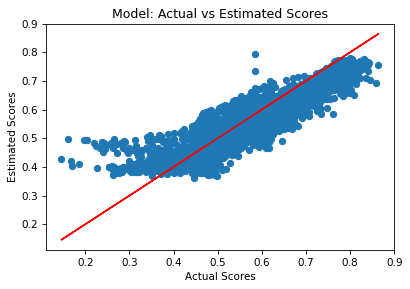

In [155]:
X_test = sm.add_constant(X_test)
Y_preds = results.predict(X_test)
plt.figure(dpi = 75)
plt.scatter(Y_test, Y_preds)
plt.plot(Y_test, Y_test, color="red")
plt.xlabel("Actual Scores")
plt.ylabel("Estimated Scores")
plt.title("Model: Actual vs Estimated Scores")
plt.show()

In [59]:
accuracy_dict = {}
for output_column in output_columns:
    Y_train = data_1[[output_column]]
    Y_test = data_2[[output_column]]
    
    model = LinearRegression()
    model.fit(X_train, Y_train)
    
    Y_train_predict = model.predict(X_train)
    Y_train_rmse = np.sqrt(mean_squared_error(Y_train, Y_train_predict))
    Y_train_r2 = r2_score(Y_train, Y_train_predict)
    print("#######################################")
    print("\n")
    print(f"output variable: {output_column}")
    print("The model performance for training set")
    print("--------------------------------------")
    print('RMSE is {}'.format(Y_train_rmse))
    print('R2 score is {}'.format(Y_train_r2))
    print("\n")


    Y_test_predict = model.predict(X_test)
    Y_test_rmse = np.sqrt(mean_squared_error(Y_test, Y_test_predict))
    Y_test_r2 = r2_score(Y_test, Y_test_predict)
    print("The model performance for test set")
    print("--------------------------------------")
    print('RMSE is {}'.format(Y_test_rmse))
    print('R2 score is {}'.format(Y_test_r2))
    print("\n")
    
    accuracy_dict[output_column] = {}
    accuracy_dict[output_column]['rmse'] = Y_test_rmse
    accuracy_dict[output_column]['r_2']  = Y_test_r2

#######################################


output variable: fx_1
The model performance for training set
--------------------------------------
RMSE is 485.7661497347855
R2 score is 0.5644200853318943


The model performance for test set
--------------------------------------
RMSE is 448.33503957491814
R2 score is 0.5557707052823954


#######################################


output variable: fy_1
The model performance for training set
--------------------------------------
RMSE is 603.9452224783892
R2 score is 0.6778659928381396


The model performance for test set
--------------------------------------
RMSE is 2921.465554364088
R2 score is -5.2539064955837365


#######################################


output variable: fz_1
The model performance for training set
--------------------------------------
RMSE is 436.1216613415004
R2 score is 0.3258991322998861


The model performance for test set
--------------------------------------
RMSE is 448.5258185002112
R2 score is 0.199156170738386